# 🎭 EMOTION DETECTION - OPTIMIZED FOR REAL-TIME

## 🎯 Objectives:
- **Balanced Performance**: Akurasi seimbang untuk semua kelas (>65%)
- **Real-time Ready**: FPS tinggi untuk webcam detection (>20 FPS)
- **Production Quality**: Stable dan reliable

## 📊 Dataset:
- Training: 20,573 images (5 kelas)
- Test: 5,114 images
- Format: 48x48 grayscale

## 🚀 Strategy:
1. ✅ Focal Loss untuk class imbalance
2. ✅ Enhanced Class Weights
3. ✅ Advanced Augmentation
4. ✅ Deep CNN Architecture
5. ✅ Real-time Optimization

In [14]:
# Cell 1: Setup & Imports
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
from datetime import datetime
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *

np.random.seed(42)
tf.random.set_seed(42)

print("="*70)
print("🎭 EMOTION DETECTION - OPTIMIZED FOR REAL-TIME")
print("="*70)
print(f"✅ TensorFlow: {tf.__version__}")
print(f"✅ Setup Complete!")
print("="*70)

🎭 EMOTION DETECTION - OPTIMIZED FOR REAL-TIME
✅ TensorFlow: 2.20.0
✅ Setup Complete!


In [15]:
# Cell 2: Focal Loss Implementation

def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss untuk mengatasi class imbalance
    Fokus pada hard examples dan minoritas kelas
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        
        cross_entropy = -y_true * K.log(y_pred)
        pt = K.sum(y_true * y_pred, axis=-1, keepdims=True)
        focal_weight = K.pow(1.0 - pt, gamma)
        alpha_weight = y_true * alpha + (1 - y_true) * (1 - alpha)
        loss = focal_weight * alpha_weight * cross_entropy
        
        return K.mean(K.sum(loss, axis=-1))
    
    return focal_loss_fixed

print("✅ Focal Loss Implementation Ready")
print("   • Gamma: 2.0 (focusing parameter)")
print("   • Alpha: 0.25 (balancing factor)")

✅ Focal Loss Implementation Ready
   • Gamma: 2.0 (focusing parameter)
   • Alpha: 0.25 (balancing factor)


In [16]:
# Cell 3: Enhanced Class Weights Calculator

def calculate_enhanced_class_weights(train_path="train", power=1.5):
    """
    Enhanced class weights dengan exponential scaling
    """
    emotion_mapping = {
        'angry': 0, 'disgusted': 1, 'fearful': 2,
        'happy': 3, 'sad': 4
    }
    
    class_counts = {}
    total_samples = 0
    
    for class_name, class_idx in emotion_mapping.items():
        class_path = Path(train_path) / class_name
        if class_path.exists():
            count = len(list(class_path.glob("*.png")))
            class_counts[class_idx] = count
            total_samples += count
    
    num_classes = len(class_counts)
    class_weights = {}
    
    for class_idx, count in class_counts.items():
        base_weight = total_samples / (num_classes * count)
        enhanced_weight = base_weight ** power
        class_weights[class_idx] = enhanced_weight
    
    # Normalize
    max_weight = max(class_weights.values())
    class_weights = {k: (v/max_weight) * 10 for k, v in class_weights.items()}
    
    print("\n⚖️  ENHANCED CLASS WEIGHTS:")
    class_names = ['MARAH', 'JIJIK', 'TAKUT', 'SENANG', 'SEDIH']
    for idx, name in enumerate(class_names):
        print(f"   {name:<10}: weight={class_weights[idx]:>5.2f}")
    
    return class_weights

enhanced_weights = calculate_enhanced_class_weights(power=1.5)


⚖️  ENHANCED CLASS WEIGHTS:
   MARAH     : weight= 0.36
   JIJIK     : weight=10.00
   TAKUT     : weight= 0.35
   SENANG    : weight= 0.15
   SEDIH     : weight= 0.27


In [17]:
# Cell 4: Advanced Data Augmentation

def create_data_generators(batch_size=32, img_size=(48, 48)):
    """
    Advanced augmentation untuk training
    """
    emotion_classes = ['angry', 'disgusted', 'fearful', 'happy', 'sad']
    
    # Training augmentation - AGRESIF
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.8, 1.2]
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        'train',
        target_size=img_size,
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical',
        classes=emotion_classes,
        shuffle=True
    )
    
    val_gen = val_datagen.flow_from_directory(
        'test',
        target_size=img_size,
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical',
        classes=emotion_classes,
        shuffle=False
    )
    
    print(f"\n📊 Data Generators Created:")
    print(f"   Train: {train_gen.samples:,} images")
    print(f"   Val: {val_gen.samples:,} images")
    print(f"   Batch size: {batch_size}")
    
    return train_gen, val_gen

train_gen, val_gen = create_data_generators(batch_size=32)

Found 20573 images belonging to 5 classes.
Found 5114 images belonging to 5 classes.

📊 Data Generators Created:
   Train: 20,573 images
   Val: 5,114 images
   Batch size: 32


In [18]:
# Cell 5: Optimized CNN Model

def create_optimized_emotion_model(num_classes=5, input_shape=(48, 48, 1)):
    """
    Deep CNN optimized untuk emotion detection real-time
    """
    print("\n🧠 Creating Optimized Emotion Model...")
    
    model = Sequential([
        Input(shape=input_shape),
        
        # Block 1
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 2
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 3
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 4
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dropout(0.5),
        
        # Classification
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(num_classes, activation='softmax')
    ], name='Optimized_Emotion_CNN')
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy']
    )
    
    model.summary()
    
    print(f"\n✅ Model Created:")
    print(f"   Parameters: {model.count_params():,}")
    print(f"   Size: ~{model.count_params() * 4 / 1024 / 1024:.1f} MB")
    
    return model

model = create_optimized_emotion_model()


🧠 Creating Optimized Emotion Model...


Model: "Optimized_Emotion_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,728,389 (10.41 MB)

 Trainable params: 2,724,037 (10.39 MB)

 Non-trainable params: 4,352 (17.00 KB)


✅ Model Created:
   Parameters: 2,728,389
   Size: ~10.4 MB


In [6]:
# Cell 6: Training with Callbacks

print("🚀 Starting Training...\n")

log_dir = f"logs/optimized_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=12,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_emotion_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    TensorBoard(log_dir=log_dir)
]

start_time = time.time()

history = model.fit(
    train_gen,
    epochs=35,
    validation_data=val_gen,
    class_weight=enhanced_weights,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
best_acc = max(history.history['val_accuracy'])

print(f"\n✅ Training Complete!")
print(f"   Time: {training_time/60:.1f} min")
print(f"   Best Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")

🚀 Starting Training...

Epoch 1/35
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.2545 - loss: 0.1791
Epoch 1: val_accuracy improved from None to 0.31952, saving model to best_emotion_model.keras
643/643 ━━━━━━━━━━━━━━━━━━━━ 457s 698ms/step - accuracy: 0.2709 - loss: 0.1503 - val_accuracy: 0.3195 - val_loss: 0.2222 - learning_rate: 0.0010
Epoch 2/35
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.3010 - loss: 0.1149
Epoch 2: val_accuracy improved from 0.31952 to 0.34904, saving model to best_emotion_model.keras
643/643 ━━━━━━━━━━━━━━━━━━━━ 487s 676ms/step - accuracy: 0.3131 - loss: 0.1107 - val_accuracy: 0.3490 - val_loss: 0.2101 - learning_rate: 0.0010
Epoch 3/35
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.3249 - loss: 0.1065
Epoch 3: val_accuracy improved from 0.34904 to 0.35706, saving model to best_emotion_model.keras
643/643 ━━━━━━━━━━━━━━━━━━━━ 429s 668ms/step - accuracy: 0.3303 - loss: 0.1061 - val_accuracy: 0.3571 - val_loss: 0.2086 - learning_ra

NameError: name 'history' is not defined

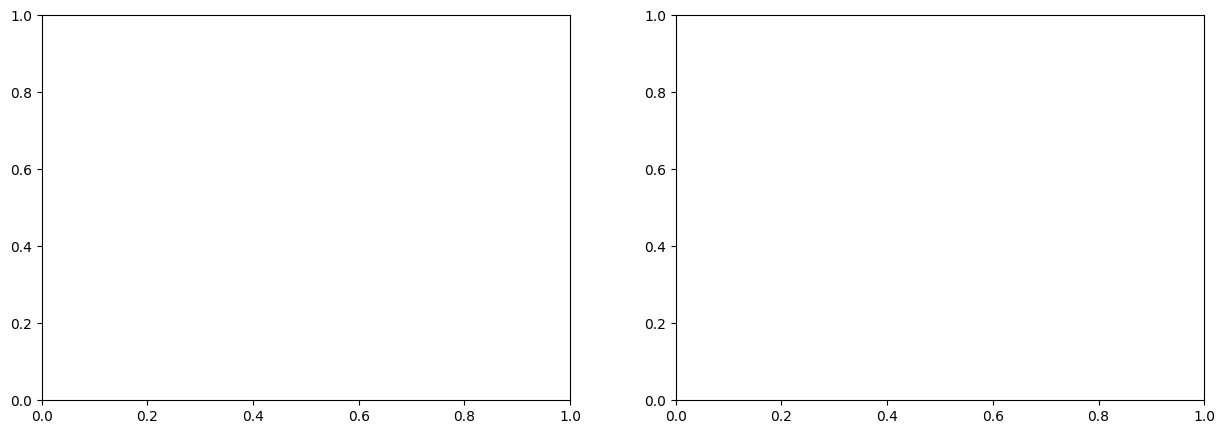

In [19]:
# Cell 7: Visualize Training Results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history.history['accuracy']) + 1)

ax1.plot(epochs_range, history.history['accuracy'], 'b-', label='Train', lw=2)
ax1.plot(epochs_range, history.history['val_accuracy'], 'r-', label='Val', lw=2)
ax1.set_title('Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_range, history.history['loss'], 'b-', label='Train', lw=2)
ax2.plot(epochs_range, history.history['val_loss'], 'r-', label='Val', lw=2)
ax2.set_title('Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best Val Accuracy: {max(history.history['val_accuracy']):.4f}")

In [10]:
# Cell 8: Comprehensive Evaluation

best_model = keras.models.load_model(
    'best_emotion_model.keras',
    custom_objects={'focal_loss_fixed': focal_loss(2.0, 0.25)}
)

print("📈 Evaluating Model...\n")

val_gen.reset()
predictions = best_model.predict(val_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_gen.classes

class_names = ['MARAH', 'JIJIK', 'TAKUT', 'SENANG', 'SEDIH']

print("\n📊 CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

print("\n📊 PER-CLASS ACCURACY:")
print("-"*60)
accuracies = []
for i, name in enumerate(class_names):
    acc = cm[i, i] / cm[i].sum()
    accuracies.append(acc)
    
    status = "✅" if acc >= 0.65 else "⚠️" if acc >= 0.55 else "❌"
    bar = "█" * int(acc * 40)
    print(f"{name:<10}: {acc:.4f} ({acc*100:>5.1f}%) {bar} {status}")

balance_score = min(accuracies) / max(accuracies)
print(f"\n⚖️  Balance Score: {balance_score:.3f}")
print(f"📊 Average Accuracy: {np.mean(accuracies):.4f}")

📈 Evaluating Model...

160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       MARAH     0.5884    0.5699    0.5790       958
       JIJIK     0.4923    0.5766    0.5311       111
       TAKUT     0.6133    0.3779    0.4677      1024
      SENANG     0.8858    0.9047    0.8951      1774
       SEDIH     0.5604    0.7249    0.6322      1247

    accuracy                         0.6856      5114
   macro avg     0.6280    0.6308    0.6210      5114
weighted avg     0.6876    0.6856    0.6783      5114


📊 PER-CLASS ACCURACY:
------------------------------------------------------------
MARAH     : 0.5699 ( 57.0%) ██████████████████████ ⚠️
JIJIK     : 0.5766 ( 57.7%) ███████████████████████ ⚠️
TAKUT     : 0.3779 ( 37.8%) ███████████████ ❌
SENANG    : 0.9047 ( 90.5%) ████████████████████████████████████ ✅
SEDIH     : 0.7249 ( 72.5%) ████████████████████████████ ✅

⚖️  Balance Score: 0.418
📊 Average Accuracy: 0.6308


In [8]:
# Cell 9: Confusion Matrix Visualization

plt.figure(figsize=(10, 8))

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'},
            linewidths=1, linecolor='gray')

plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix saved!")

NameError: name 'cm' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
# Cell 10: Real-time Webcam Detection

def realtime_emotion_detection():
    """
    Real-time emotion detection dengan webcam
    Optimized untuk FPS tinggi
    """
    model = keras.models.load_model(
        'best_emotion_model.keras',
        custom_objects={'focal_loss_fixed': focal_loss(2.0, 0.25)}
    )
    
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    )
    
    emotions = ['MARAH', 'JIJIK', 'TAKUT', 'SENANG', 'SEDIH']
    colors = [(0,0,255), (0,255,255), (128,0,128), (0,255,0), (255,0,0)]
    
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    cap.set(cv2.CAP_PROP_FPS, 30)
    
    print("\n📹 Real-time Detection Started")
    print("   Press 'Q' to quit")
    print("   Press 'S' to save screenshot\n")
    
    fps_time = time.time()
    fps = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.flip(frame, 1)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        faces = face_cascade.detectMultiScale(
            gray, scaleFactor=1.1, minNeighbors=5,
            minSize=(48, 48), maxSize=(300, 300)
        )
        
        for (x, y, w, h) in faces:
            face = cv2.resize(gray[y:y+h, x:x+w], (48, 48))
            face_input = face.reshape(1, 48, 48, 1) / 255.0
            
            pred = model.predict(face_input, verbose=0)
            idx = np.argmax(pred)
            emotion = emotions[idx]
            confidence = pred[0][idx] * 100
            
            # Draw rectangle dan text
            cv2.rectangle(frame, (x, y), (x+w, y+h), colors[idx], 3)
            
            # Background untuk text
            text = f'{emotion}: {confidence:.1f}%'
            (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
            cv2.rectangle(frame, (x, y-th-10), (x+tw+10, y), colors[idx], -1)
            cv2.putText(frame, text, (x+5, y-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
        
        # FPS counter
        if time.time() - fps_time > 1:
            fps_time = time.time()
            fps = fps * 0.7 + 0.3 / (time.time() - fps_time)
        
        cv2.putText(frame, f'FPS: {int(fps)}', (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        
        cv2.imshow('Emotion Detection - Press Q to Quit', frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            filename = f'screenshot_{datetime.now().strftime("%Y%m%d_%H%M%S")}.jpg'
            cv2.imwrite(filename, frame)
            print(f"   Screenshot saved: {filename}")
    
    cap.release()
    cv2.destroyAllWindows()
    print("\n✅ Session ended")

# Run detection
realtime_emotion_detection()


📹 Real-time Detection Started
   Press 'Q' to quit
   Press 'S' to save screenshot

